# Policy Gradients: REINFORCE with LunarLander

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

In [2]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### LunarLander

LunarLander is an OpenAI gym environment (env). In this env the agent tries to land a space craft safely on the ground by firing the main, left, or right engine. The agent receives a reward for navigating to the landing pad and turning off the engine, a large reward for a safe landing, a large negative reward for an unsafe landing, and a small negative reward for using the engines. There are discrete and continuous versions of LunarLander.

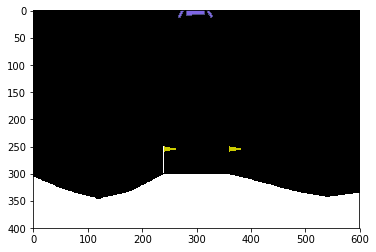

In [3]:
env = gym.make('LunarLander-v2')
env.reset()

prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(200):
    env.render()
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        env.reset()
        
env.close()

### Policy Gradient Methods

In policy gradient methods, we update the policy directly. Ie we parameterize the policy and perform gradient descent updates on the policy parameters seeking to improve the policy. This is in contrast to section 3 where we learned estimates of the state or action-values. Then we extracted a policy based on those values, like with the epsilon greedy DQN policy.

### Discrete vs. Continuous Action Spaces

PG methods can work in discrete and continuous action spaces. The DQN method we went over in section three required discrete action spaces: ie a limited number of actions. In continuous actions spaces there are an infinite number of actions as the action can be any value in a range. Continuous action spaces are often parameterized by a probability distribution and we learn the parameters of the distribution. For example we assume the actions come from a Gaussian distribution and try to learn the mean and standard deviation of the Gaussian that leads to the best policy. 

### REINFORCE with Lunar Lander

In this example, we will solve the discrete version of Lunar Lander using the REINFORCE method.

In [4]:
class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
    
    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return F.softmax(self.output(x),dim=-1) #-1 to take softmax of last dimension

In [5]:
class PGAgent():
    def __init__(self, state_size, action_size, hidden_size, learning_rate, discount ):
        self.action_size = action_size
        self.actor_net = ActorNet(state_size, action_size, hidden_size).to(device)
        self.optimizer = optim.Adam(self.actor_net.parameters(), lr=learning_rate)
        self.discount = discount
        
    def select_action(self, state):
        #get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action_probs = self.actor_net(input_state)
            #detach and turn to numpy to use with np.random.choice()
            action_probs = action_probs.detach().cpu().numpy()
            action = np.random.choice(np.arange(self.action_size), p=action_probs)
        return action

    def train(self, state_list, action_list, reward_list):
        
        #turn rewards into return
        trajectory_len = len(reward_list)
        return_array = np.zeros((trajectory_len,))
        g_return = 0.
        for i in range(trajectory_len-1,-1,-1):
            g_return = reward_list[i] + self.discount*g_return
            return_array[i] = g_return
            
        # create tensors
        state_t = torch.FloatTensor(state_list).to(device)
        action_t = torch.LongTensor(action_list).to(device).view(-1,1)
        return_t = torch.FloatTensor(return_array).to(device).view(-1,1)
        
        selected_action_prob = self.actor_net(state_t).gather(1, action_t)
        loss = torch.mean(-torch.log(selected_action_prob) * return_t)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step() 

        return loss.detach().cpu().numpy()
    

In [6]:
# initialize environment
env = gym.make('LunarLander-v2')
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
episodes = 5000 # run agent for this many episodes
hidden_size = 256 # number of units in NN hidden layers
learning_rate = 0.0005 # learning rate for optimizer
discount = 0.99 # discount factor gamma value
reward_scale = 0.01 #scale reward by this amount

# create agent
agent = PGAgent(state_size, action_size, hidden_size, learning_rate, discount)
        

In [7]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0

for ep in range(episodes):
    state = env.reset()
    stats_loss = 0.
    
    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  
    
    state_list = []
    action_list = []
    reward_list = []
    
    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy
        action = agent.select_action(state)
        
        # enter action into the env
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        episode_length += 1
        # store agent's trajectory
        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward*reward_scale)
        
        # end episode early
        if total_reward < -250:
            done = 1
        
        if done:
            stats_loss += agent.train(state_list, action_list, reward_list)
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0  
            if ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Loss: {:.3f}'.format(stats_loss/stats_every))
            break
        
        state = next_state


Episode: 0 Timestep: 58 Total reward: -112.2 Episode length: 58.0 Loss: -0.102
Episode: 10 Timestep: 943 Total reward: -192.9 Episode length: 88.5 Loss: -0.211
Episode: 20 Timestep: 1936 Total reward: -121.6 Episode length: 99.3 Loss: -0.055
Episode: 30 Timestep: 2909 Total reward: -198.3 Episode length: 97.3 Loss: -0.098
Episode: 40 Timestep: 4017 Total reward: -169.0 Episode length: 110.8 Loss: -0.067
Episode: 50 Timestep: 5037 Total reward: -189.9 Episode length: 102.0 Loss: -0.123
Episode: 60 Timestep: 6111 Total reward: -209.9 Episode length: 107.4 Loss: -0.154
Episode: 70 Timestep: 7269 Total reward: -122.5 Episode length: 115.8 Loss: -0.007
Episode: 80 Timestep: 8143 Total reward: -111.0 Episode length: 87.4 Loss: -0.092
Episode: 90 Timestep: 9065 Total reward: -153.9 Episode length: 92.2 Loss: -0.043
Episode: 100 Timestep: 10124 Total reward: -135.8 Episode length: 105.9 Loss: -0.139
Episode: 110 Timestep: 11246 Total reward: -146.4 Episode length: 112.2 Loss: -0.066
Episode: 1

Episode: 980 Timestep: 340040 Total reward: -19.5 Episode length: 921.0 Loss: -0.010
Episode: 990 Timestep: 348516 Total reward: -15.1 Episode length: 847.6 Loss: 0.014
Episode: 1000 Timestep: 355249 Total reward: 12.5 Episode length: 673.3 Loss: 0.003
Episode: 1010 Timestep: 362682 Total reward: 27.1 Episode length: 743.3 Loss: 0.003
Episode: 1020 Timestep: 368456 Total reward: 21.2 Episode length: 577.4 Loss: 0.023
Episode: 1030 Timestep: 376026 Total reward: -0.7 Episode length: 757.0 Loss: -0.005
Episode: 1040 Timestep: 383128 Total reward: -19.3 Episode length: 710.2 Loss: -0.017
Episode: 1050 Timestep: 391562 Total reward: -4.1 Episode length: 843.4 Loss: -0.007
Episode: 1060 Timestep: 400341 Total reward: -108.1 Episode length: 877.9 Loss: -0.001
Episode: 1070 Timestep: 409935 Total reward: -73.7 Episode length: 959.4 Loss: -0.031
Episode: 1080 Timestep: 419154 Total reward: -13.8 Episode length: 921.9 Loss: -0.001
Episode: 1090 Timestep: 426301 Total reward: -27.6 Episode lengt

Episode: 1950 Timestep: 1134798 Total reward: 15.9 Episode length: 1000.0 Loss: 0.001
Episode: 1960 Timestep: 1144035 Total reward: -44.2 Episode length: 923.7 Loss: -0.001
Episode: 1970 Timestep: 1154035 Total reward: 14.7 Episode length: 1000.0 Loss: 0.002
Episode: 1980 Timestep: 1163291 Total reward: 31.1 Episode length: 925.6 Loss: 0.001
Episode: 1990 Timestep: 1173291 Total reward: 25.1 Episode length: 1000.0 Loss: 0.001
Episode: 2000 Timestep: 1183291 Total reward: 29.3 Episode length: 1000.0 Loss: 0.001
Episode: 2010 Timestep: 1192259 Total reward: 10.2 Episode length: 896.8 Loss: -0.000
Episode: 2020 Timestep: 1201426 Total reward: 24.5 Episode length: 916.7 Loss: 0.002
Episode: 2030 Timestep: 1211426 Total reward: 27.4 Episode length: 1000.0 Loss: -0.004
Episode: 2040 Timestep: 1220626 Total reward: 21.3 Episode length: 920.0 Loss: -0.002
Episode: 2050 Timestep: 1230196 Total reward: -13.6 Episode length: 957.0 Loss: -0.003
Episode: 2060 Timestep: 1239719 Total reward: 20.2 Ep

Episode: 2910 Timestep: 2045123 Total reward: 133.1 Episode length: 842.3 Loss: 0.008
Episode: 2920 Timestep: 2052612 Total reward: 131.2 Episode length: 748.9 Loss: 0.008
Episode: 2930 Timestep: 2059238 Total reward: 87.0 Episode length: 662.6 Loss: -0.006
Episode: 2940 Timestep: 2068212 Total reward: 112.7 Episode length: 897.4 Loss: 0.000
Episode: 2950 Timestep: 2077991 Total reward: 78.8 Episode length: 977.9 Loss: 0.004
Episode: 2960 Timestep: 2087991 Total reward: 76.0 Episode length: 1000.0 Loss: 0.002
Episode: 2970 Timestep: 2097991 Total reward: 97.4 Episode length: 1000.0 Loss: 0.002
Episode: 2980 Timestep: 2107114 Total reward: 93.1 Episode length: 912.3 Loss: 0.008
Episode: 2990 Timestep: 2117114 Total reward: 121.4 Episode length: 1000.0 Loss: 0.008
Episode: 3000 Timestep: 2126235 Total reward: 124.8 Episode length: 912.1 Loss: 0.008
Episode: 3010 Timestep: 2135345 Total reward: 126.5 Episode length: 911.0 Loss: 0.006
Episode: 3020 Timestep: 2144513 Total reward: 114.6 Epi

Text(0, 0.5, 'Episode Reward')

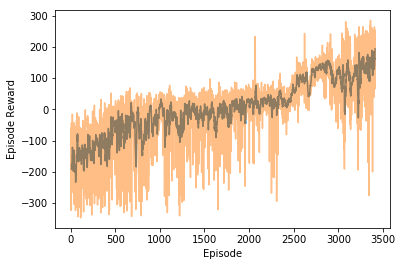

In [8]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

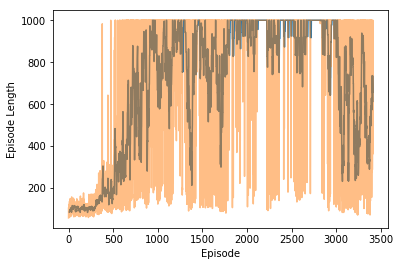

In [9]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')